In [1]:
import sqlite3
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
con = sqlite3.connect('touches.sqlite3')
cur=con.cursor()

# Question # 1. Find the most common industry out of all the companies that were contacted.
#Answer: Internet Software & Services
#Internet Software & Services has most number of completed touches

In [2]:
#Question # 1. Find the most common industry out of all the companies that were contacted.
cur.execute('select a.industry, count(c.status) as count from \
companies a \
inner join \
persons b \
on a.id=b.company_id \
inner join \
(select * from touches where lower(trim(status))="completed") c \
on b.id=c.person_id group by a.industry order by count desc limit 1')
cur.fetchall()

[('Internet Software & Services', 248155)]

# Question 2. What is the most common touch type sellers use when they’re making their first touch with a person? What about first touch with a company?.
#Answer: Other for both companies and persons

In [3]:
cur.execute('select touch_type, count(distinct person_id) count from (select person_id, touch_type, \
            row_number() over(partition by person_id order by touch_scheduled_on) as row_no \
            from touches where status="completed") a\
            where row_no=1 \
            group by touch_type order by count desc limit 1')
cur.fetchall()

[('Other', 31105)]

In [4]:
cur.execute('select touch_type, count(distinct company_id) count from (select a.company_id, b.touch_type, touch_scheduled_on, \
row_number() over(partition by company_id order by b.touch_scheduled_on) as row_no from \
persons a \
inner join \
(select * from touches where lower(trim(status))="completed") b \
on a.id=b.person_id) a where row_no=1 group by touch_type order by count desc limit 1' )
cur.fetchall()

[('Other', 4984)]

# Question 3. Describe the distribution of the job seniorities of people that a seller will first try to contact within a company.
#Below is the list of most frequently contacted first job seniority tole in descending order.
#Director is the most frequently contacted followed by Vice President and so on (Code block 7)
#Director
#Vice President
#Manager
#Executive
#Unknown

#Other remains the most used method of first touch across all the job seniorities. (Code block 12)
#Most number of opportunities are won when a job seniority of "Unkown" is contacted first. (Code block 16)

In [5]:
cur.execute('drop table if exists job_desc_q3')
cur.execute('create table job_desc_q3 as select * from (select a.company_id, a.id person_id, b.touch_type, \
a.job_seniority, b.touch_scheduled_on, \
row_number() over(partition by a.company_id, a.job_seniority order by b.touch_scheduled_on) as row_no from \
persons a \
inner join \
(select * from touches where lower(trim(status))="completed") b \
on a.id=b.person_id) a where row_no=1' )
cur.fetchall()

[]

In [6]:
cur.execute('select job_seniority, count(*) count from job_desc_q3 group by job_seniority order by count desc')
df_jd_count=pd.DataFrame(cur.fetchall())
df_jd_count.rename(columns = {0:'Job_Description',1:'First_Touches'}, inplace = True)
df_jd_count

,Job_Description,First_Touches
0,Director,6448
1,Vice President,5925
2,Manager,5115
3,Executive,4199
4,Individual Contributor,3514
5,Unknown,1841


<Figure size 1080x720 with 0 Axes>

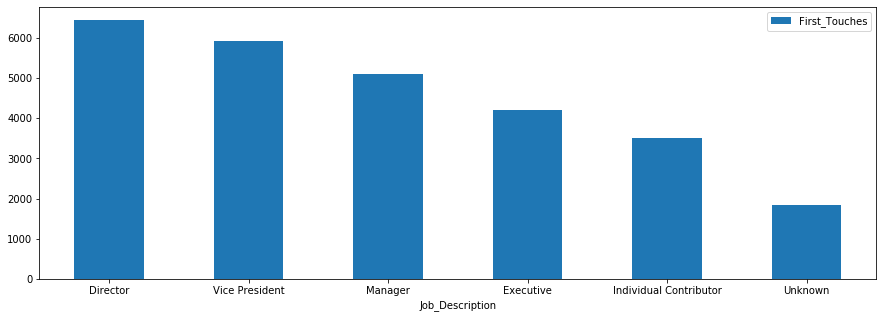

In [7]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.figure(figsize=(15,10))

df_jd_count.plot.bar(x='Job_Description',y='First_Touches',rot=0,figsize=(15, 5))


In [8]:
#Director is the most frequently contacted followed by Vice President and so on
#Director
#Vice President
#Manager
#Executive
#Unknown

In [9]:
#Getting the touch types across job seniorities
cur.execute('select job_seniority, touch_type, count(*) count from job_desc_q3 group by job_seniority, touch_type order by job_seniority, touch_type, count desc')
df_jd_ft_count=pd.DataFrame(cur.fetchall())
df_jd_ft_count.rename(columns = {0:'Job_Description',1:'Touch_Type',2:'First_Touches'}, inplace = True)
df_jd_ft_count.head(5)

,Job_Description,Touch_Type,First_Touches
0,Director,Email,1900
1,Director,Integration,60
2,Director,Other,3404
3,Director,Phone,1084
4,Executive,Email,1249


In [10]:
#Creating a new data set which contains the job descriptions and a column for each of the touch types
cur.execute('select job_seniority, touch_type, count(*) count from job_desc_q3 where touch_type="Email" group by job_seniority, touch_type order by job_seniority, touch_type, count desc')
df_jd_ft_email=pd.DataFrame(cur.fetchall())
df_jd_ft_email.rename(columns = {0:'Job_Description',1:'Touch_Type',2:'Email'}, inplace = True)
df_jd_ft_email = df_jd_ft_email[["Job_Description","Email"]]

cur.execute('select job_seniority, touch_type, count(*) count from job_desc_q3 where touch_type="Integration" group by job_seniority, touch_type order by job_seniority, touch_type, count desc')
df_jd_ft_integration=pd.DataFrame(cur.fetchall())
df_jd_ft_integration.rename(columns = {0:'Job_Description',1:'Touch_Type',2:'Integration'}, inplace = True)
df_jd_ft_integration = df_jd_ft_integration[["Job_Description","Integration"]]

cur.execute('select job_seniority, touch_type, count(*) count from job_desc_q3 where touch_type="Other" group by job_seniority, touch_type order by job_seniority, touch_type, count desc')
df_jd_ft_other=pd.DataFrame(cur.fetchall())
df_jd_ft_other.rename(columns = {0:'Job_Description',1:'Touch_Type',2:'Other'}, inplace = True)
df_jd_ft_other = df_jd_ft_other[["Job_Description","Other"]]

cur.execute('select job_seniority, touch_type, count(*) count from job_desc_q3 where touch_type="Phone" group by job_seniority, touch_type order by job_seniority, touch_type, count desc')
df_jd_ft_phone=pd.DataFrame(cur.fetchall())
df_jd_ft_phone.rename(columns = {0:'Job_Description',1:'Touch_Type',2:'Phone'}, inplace = True)
df_jd_ft_phone = df_jd_ft_phone[["Job_Description","Phone"]]

In [11]:
#Creating a new data set which contains the job descriptions and a column for each of the touch types...done
df_jb_ft_dist_q3 = pd.concat([df_jd_ft_email,df_jd_ft_integration[["Integration"]],df_jd_ft_other[["Other"]],df_jd_ft_phone[["Phone"]]], axis=1)
df_jb_ft_dist_q3

,Job_Description,Email,Integration,Other,Phone
0,Director,1900,60,3404,1084
1,Executive,1249,61,2191,698
2,Individual Contributor,1280,46,1662,526
3,Manager,1397,51,2833,834
4,Unknown,791,23,766,261
5,Vice President,1674,57,3155,1039


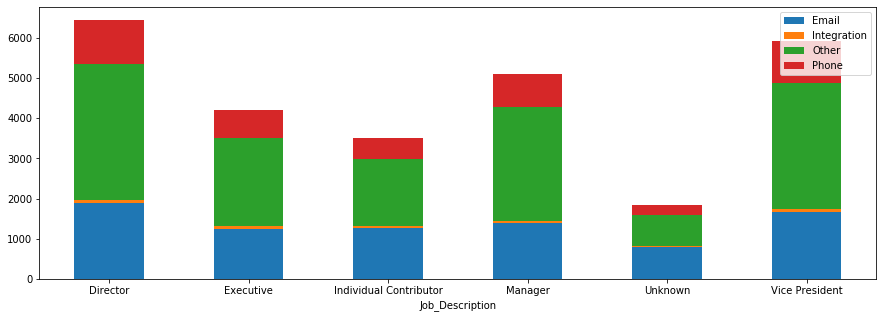

In [12]:
#plotting the first touch types across job seniorities
df_jb_ft_dist_q3.plot.bar(x='Job_Description', stacked=True, rot=0,figsize=(15, 5));

In [13]:
#cur.execute('drop table jb_opp_scr')
#Generating an oppotunity score for each of the job seniorities when they were contacted first
#3 for "Closed Won"
#0 for ("Closed Lost","Disqualified")
#1 for opportunities in-progress
#The above score assignment can be modified per personal or business choice
cur.execute('select a.*, case when latest_stage="Closed Won" then 3 \
            when latest_stage in ("Closed Lost","Disqualified") then 0\
            else 1 end as opportunity_score \
            from job_desc_q3 a inner join opportunities b on a.company_id=b.company_id \
            and trim(a.touch_scheduled_on)=substr(b.created_at,0,11)')
df_job_opp_scr=pd.DataFrame(cur.fetchall())
df_job_opp_scr

,0,1,2,3,4,5,6
0,50,2252,Other,Individual Contributor,2018-06-26,1,0
1,74,2810,Phone,Individual Contributor,2018-08-14,1,0
2,190,6218,Other,Vice President,2018-07-16,1,0
3,276,10309,Other,Director,2018-01-05,1,0
4,276,10322,Email,Vice President,2018-01-05,1,0
...,...,...,...,...,...,...,...
391,8155,233244,Integration,Vice President,2018-12-19,1,0
392,8158,233265,Email,Manager,2018-12-21,1,0
393,8158,233266,Email,Unknown,2018-12-21,1,0
394,8174,233506,Email,Director,2018-08-22,1,0


In [14]:
df_job_opp_scr.rename(columns = {0:'company_id',1:'person_id',2:'touch_type',3:'job_seniority',4:'touch_date',5:'row_no',6:'opp_score'}, inplace = True)

In [15]:
#Calculating the average opportunity score for each of the job seniorities when they were contacted first
cur.execute('select job_seniority, avg(opportunity_score) opp_scr from (select a.*, case when latest_stage="Closed Won" then 3 \
            when latest_stage in ("Closed Lost","Disqualified") then 0\
            else 1 end as opportunity_score \
            from job_desc_q3 a inner join opportunities b on a.company_id=b.company_id \
            and trim(a.touch_scheduled_on)=substr(b.created_at,0,11)) c group by job_seniority order by opp_scr desc')
df_job_opp_scr_q3=pd.DataFrame(cur.fetchall())
df_job_opp_scr_q3.rename(columns = {0:'job_description',1:'opportunity_score'}, inplace = True)
df_job_opp_scr_q3

,job_description,opportunity_score
0,Unknown,1.073171
1,Director,0.764045
2,Executive,0.657895
3,Manager,0.633803
4,Individual Contributor,0.547619
5,Vice President,0.545455


<Figure size 1080x720 with 0 Axes>

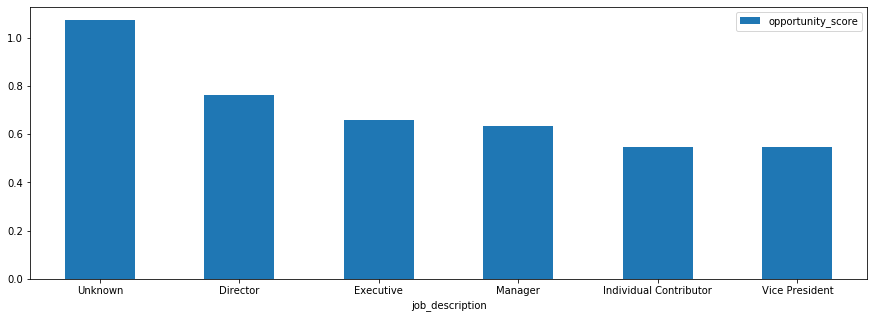

In [16]:
plt.figure(figsize=(15,10))

df_job_opp_scr_q3.plot.bar(x='job_description',y='opportunity_score',rot=0,figsize=(15, 5))


In [17]:
#Most number of opportunities are won when a job seniority of "Unkown" is contacted first.

# Question 4. Describe the distribution of the mixture of job seniorities of people that a seller will touch during the entire engagement with a company.

#I defined the mixture as the group of people who were contacted at a company. 
#The mixture varies across each of companies and within companies and all opportunities made at a company as assumed as part of one mixture
#The combination of Vice President, Executive, Manager, Individual Contributor, Director gets the most touches (Code block 22)

In [18]:
#Creating base data frame for companies, touches and job seniorities
cur.execute('drop table if exists job_desc_q4')
cur.execute('create table job_desc_q4 as select * from (select a.company_id, a.id person_id, b.touch_type, \
a.job_seniority, b.touch_scheduled_on, \
row_number() over(partition by a.company_id, a.job_seniority order by b.touch_scheduled_on) as row_no from \
persons a \
inner join \
(select * from touches where lower(trim(status))="completed") b \
on a.id=b.person_id) a order by row_no' )
cur.fetchall()

[]

In [19]:
#Renaming the columns
cur.execute('select * from job_desc_q4')
df_job_desc_q4=pd.DataFrame(cur.fetchall())
df_job_desc_q4.rename(columns = {0:'company_id',1:'person_id',2:'touch_type',3:'job_seniority',4:'touch_scheduled_on',5:'row_no'}, inplace = True)
df_job_desc_q4.head(5)

,company_id,person_id,touch_type,job_seniority,touch_scheduled_on,row_no
0,1,82,Phone,Director,2017-06-01,1
1,1,111,Email,Executive,2018-05-16,1
2,1,91,Email,Individual Contributor,2019-05-28,1
3,1,84,Email,Manager,2017-06-15,1
4,1,66,Phone,Vice President,2017-06-01,1


In [20]:
#Creating a mixture of job seniorities and the touch count for each mixture at each company
df_job_desc_q4_updated=df_job_desc_q4.groupby("company_id").agg({
    "job_seniority": lambda x: set(x),'touch_type': ['count']
})
df_job_desc_q4_updated.head(5)

,job_seniority,touch_type
,<lambda>,count
company_id,,
1,"{Director, Executive, Individual Contributor, ...",57
2,"{Executive, Manager, Director}",14
4,"{Vice President, Manager}",2
6,"{Vice President, Manager, Director}",10
8,{Individual Contributor},2


In [21]:
# Getting the mixture of job seniorities and total sum of touches  for each of the mixture
df_job_desc_q4_updated=df_job_desc_q4.groupby("company_id").agg({
    "job_seniority": lambda x: frozenset(x),'touch_type': ['count']
}).reset_index().rename(columns={'company_id':'company_id','job_seniority' : 'job_seniority_set','touch_type':'touch_count'})
df_job_desc_q4_updated_new=df_job_desc_q4_updated
df_job_desc_q4_updated_new.columns = [''] * len(df_job_desc_q4_updated_new.columns)
df_job_desc_q4_updated_new.columns =['company_id', 'job_sen_set', 'touch_count']
df_job_desc_q4_updated_new_1=df_job_desc_q4_updated_new.groupby("job_sen_set").agg({'touch_count': ['sum']}).reset_index().rename(columns={'job_sen_set' : 'job_sen_set','touch_count':'touch_count'})
df_job_desc_q4_updated_new_1.columns = [''] * len(df_job_desc_q4_updated_new_1.columns)
df_job_desc_q4_updated_new_1.columns =['job_sen_set', 'touch_count']
df_job_desc_q4_updated_new_1=df_job_desc_q4_updated_new_1.sort_values(by='touch_count', ascending=False)
df_job_desc_q4_updated_new_1

,job_sen_set,touch_count
42,"(Director, Executive, Individual Contributor, ...",94614
62,"(Director, Executive, Individual Contributor, ...",72782
39,"(Executive, Vice President, Manager, Director)",51880
38,"(Vice President, Individual Contributor, Manag...",36989
30,"(Vice President, Manager, Director)",31636
...,...,...
21,"(Individual Contributor, Unknown)",494
33,"(Executive, Individual Contributor, Vice Presi...",473
31,"(Executive, Individual Contributor, Unknown)",266
61,"(Executive, Individual Contributor, Manager, U...",222


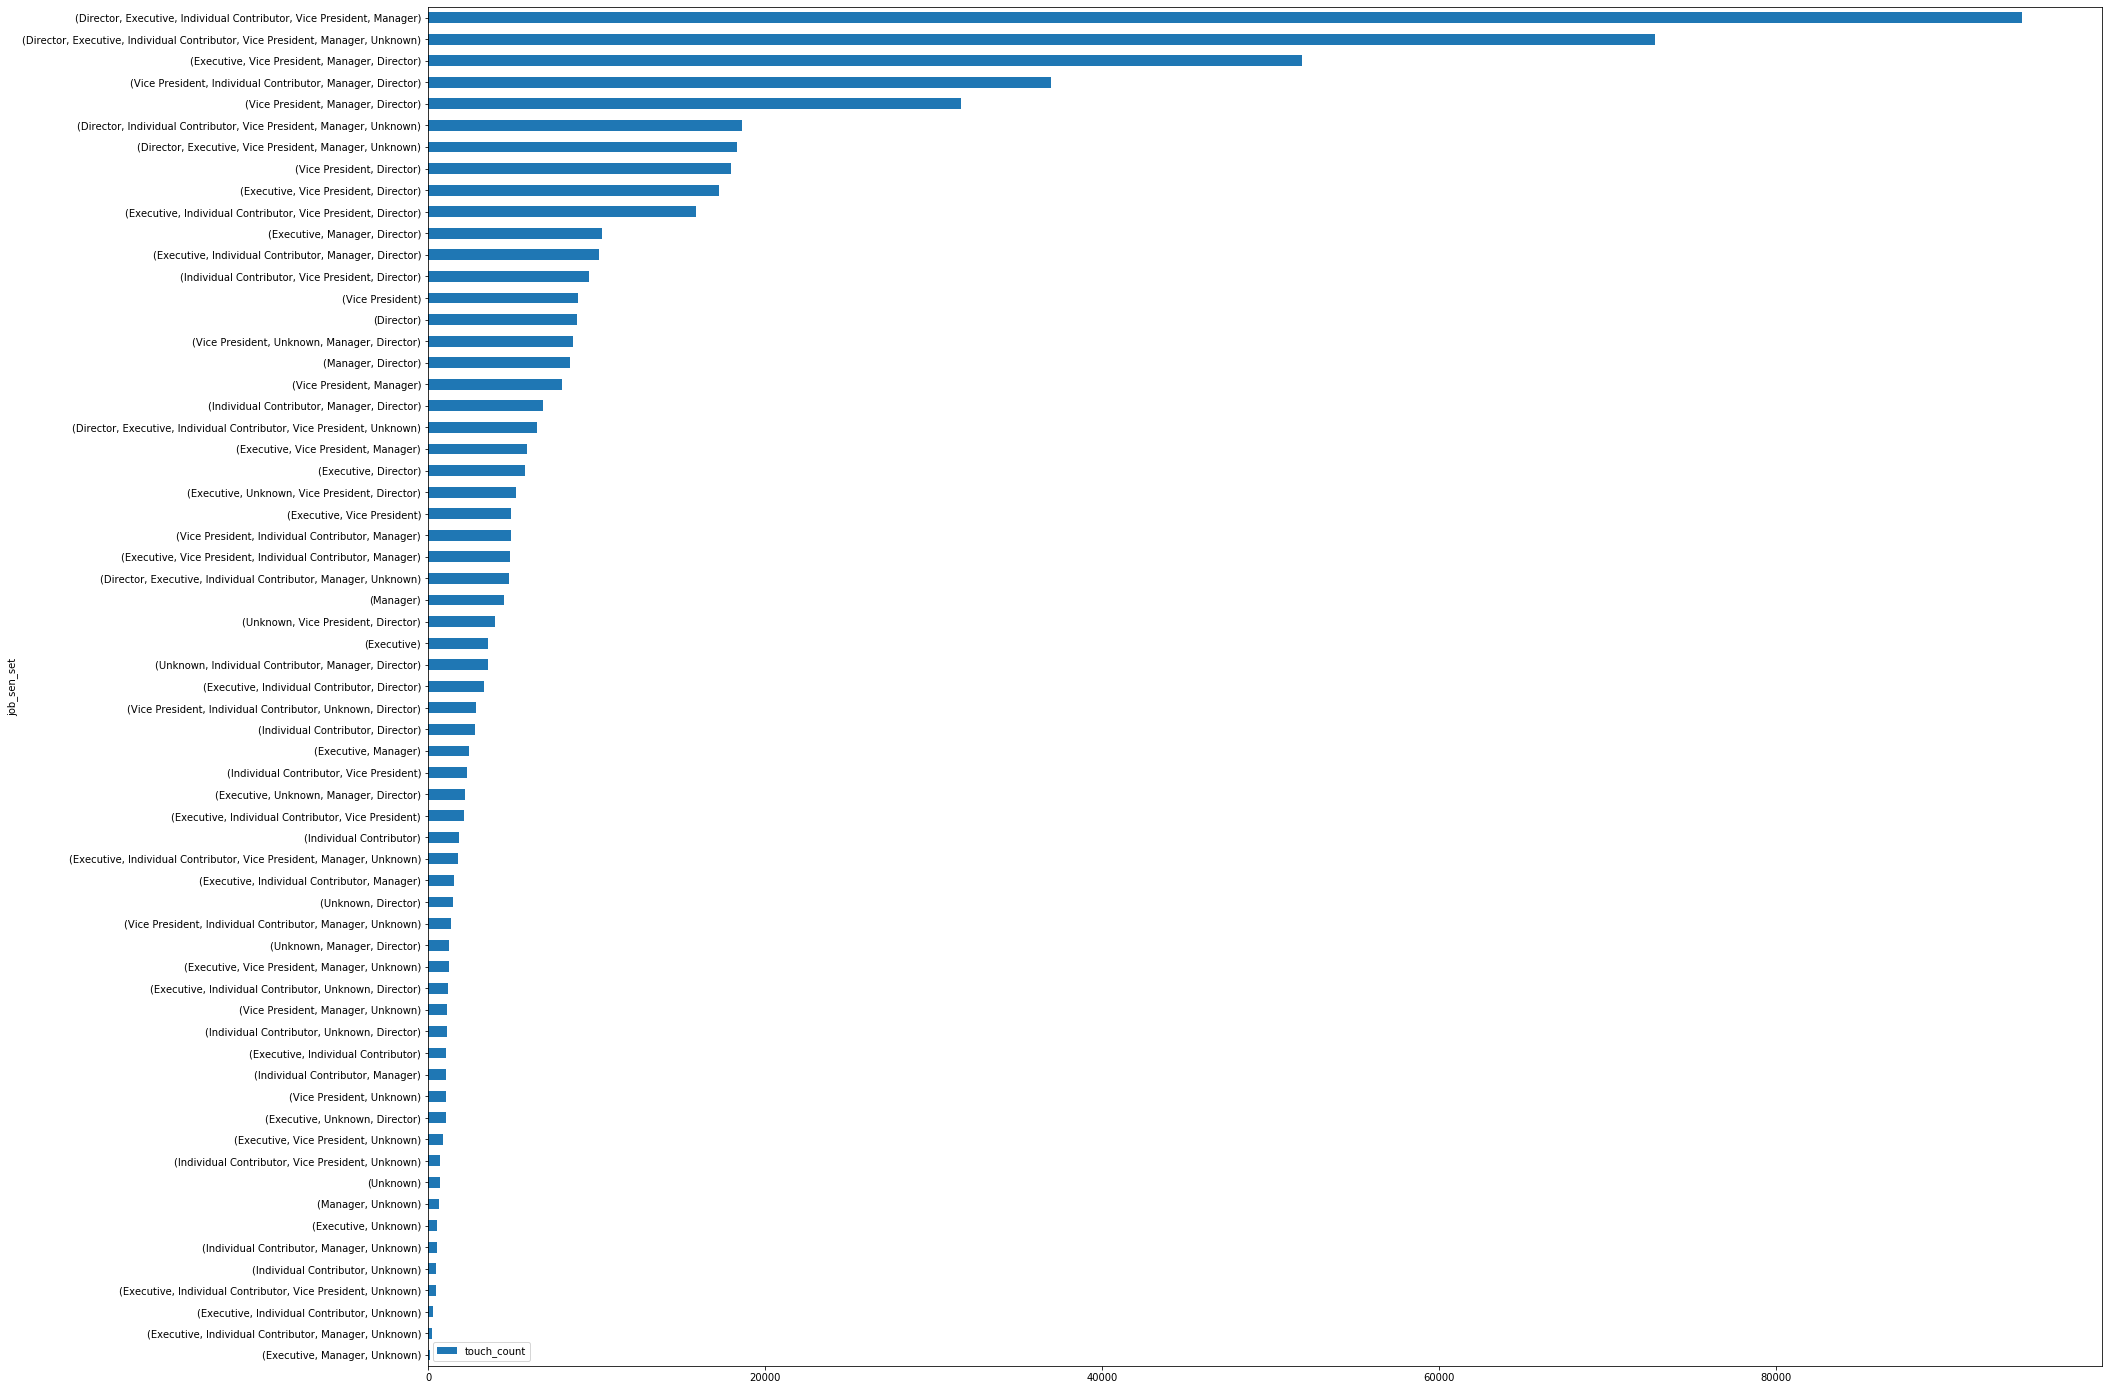

In [22]:
df_job_desc_q4_updated_new_1.sort_values(by='touch_count', ascending=True).plot.barh(x='job_sen_set', y='touch_count', rot=0,figsize=(30, 25));

In [23]:
#The combination of Vice President, Executive, Manager, Individual Contributor, Director gets the most touches

# Question 5. Build an algorithm that, when a seller is about to contact a company it never reached out to before, recommends the best/optimal mixture of job seniorities (with “mixture” as defined by you in Question 4.) they should be targeting within that company during the entire engagement.

#I would approach by ranking each of the mixture against the below approached:
#Approach 1. average of opportunity score (0 for ("Closed Lost","Disqualified") , 3 for "Closed Won", 1 otherwise) (Code block 28)
#Appproach 2. opportunities closed (Code block 32)

#For calculating the average opportunity score, I would calculate averae opportunity sccore for each job mixture at each company #and then calculate the overall average for each job seniority

#Based on the analysis above the mixture of (Director, Unknown) and (Vice President, Excutive, Unknown) have thhe highest average opportunity score
#Whereas contacting director (mixture has just one job seniority here) alone has resulted in more opportunities won

#I have done this across all the industry types, this can be customized across industries and have an individual model across
#each of the industries

A machine learning algorithm such as decision trees or random forests can also be used against the dataset which contains the touch type, inudustry, opportunities won, month of the year, mixture to determine the best mixture which gives the highest opportunity score.


# Question 5
#Approach 1: This part of the code is to calculate the average opportunity score for each job mixture

In [24]:
#Creating base line, getting job_seniorty, company_id, latest_stage (opportunity status)
cur.execute('drop table if exists job_desc_q5')
cur.execute('create table job_desc_q5 as select * from (select a.company_id, a.id person_id, b.touch_type, \
a.job_seniority, b.touch_scheduled_on, c.latest_stage,\
row_number() over(partition by a.company_id, a.job_seniority order by b.touch_scheduled_on) as row_no from \
persons a \
inner join \
(select * from touches where lower(trim(status))="completed") b \
on a.id=b.person_id \
inner join \
opportunities c \
on trim(b.touch_scheduled_on)=substr(c.created_at,0,11) and a.company_id=c.company_id) k' )
cur.fetchall()

[]

In [25]:
#Generating opportunity score
cur.execute('select distinct company_id,job_seniority, case when latest_stage="Closed Won" then 3 \
            when latest_stage in ("Closed Lost","Disqualified") then 0 \
            else 1 end as opportunity_score from job_desc_q5')
df_job_desc_q5=pd.DataFrame(cur.fetchall())

df_job_desc_q5.rename(columns = {0:'company_id',1:'job_seniority',2:'opportunity_score'}, inplace = True)

df_job_desc_q5.head(5)

,company_id,job_seniority,opportunity_score
0,23,Director,0
1,26,Manager,0
2,40,Director,0
3,40,Executive,0
4,40,Vice President,0


In [26]:
#Calculating average opportunity score at a company and job seniority mixture
df_job_desc_q5_updated=df_job_desc_q5.groupby("company_id").agg({
    "job_seniority": lambda x: frozenset(x),'opportunity_score': ['mean']
}).reset_index().rename(columns={'company_id':'company_id','job_seniority' : 'job_seniority_set','opportunity_score':'opportunity_sccore'})
df_job_desc_q5_updated_new=df_job_desc_q5_updated
df_job_desc_q5_updated_new.columns = [''] * len(df_job_desc_q5_updated_new.columns)
df_job_desc_q5_updated_new.columns =['company_id', 'job_sen_set', 'avg_opp_score']
df_job_desc_q5_updated_new

,company_id,job_sen_set,avg_opp_score
0,23,(Director),0
1,26,(Manager),0
2,40,"(Executive, Vice President, Director)",0
3,50,"(Individual Contributor, Vice President, Direc...",0
4,55,(Executive),0
...,...,...,...
1032,8158,"(Manager, Unknown)",0
1033,8174,(Director),0
1034,8244,(Individual Contributor),0
1035,8259,(Director),0


In [27]:
#Calculating overall average opportunity score for each job seniority mixture
df_job_desc_q5_updated_new_1=df_job_desc_q5_updated_new.groupby("job_sen_set").agg({'avg_opp_score': ['mean']}).reset_index().rename(columns={'job_sen_set' : 'job_sen_set','avg_opp_score':'avg_opp_score'})
df_job_desc_q5_updated_new_1.columns = [''] * len(df_job_desc_q5_updated_new_1.columns)
df_job_desc_q5_updated_new_1.columns =['job_sen_set', 'avg_opp_score']
df_job_desc_q5_updated_new_1=df_job_desc_q5_updated_new_1.sort_values(by='avg_opp_score', ascending=False)
df_job_desc_q5_updated_new_1.head(5)

,job_sen_set,avg_opp_score
2,"(Executive, Vice President, Unknown)",3.000000
16,"(Unknown, Director)",3.000000
22,"(Vice President, Manager, Unknown)",1.500000
1,"(Individual Contributor, Manager)",1.500000
7,"(Vice President, Individual Contributor, Manager)",1.333333


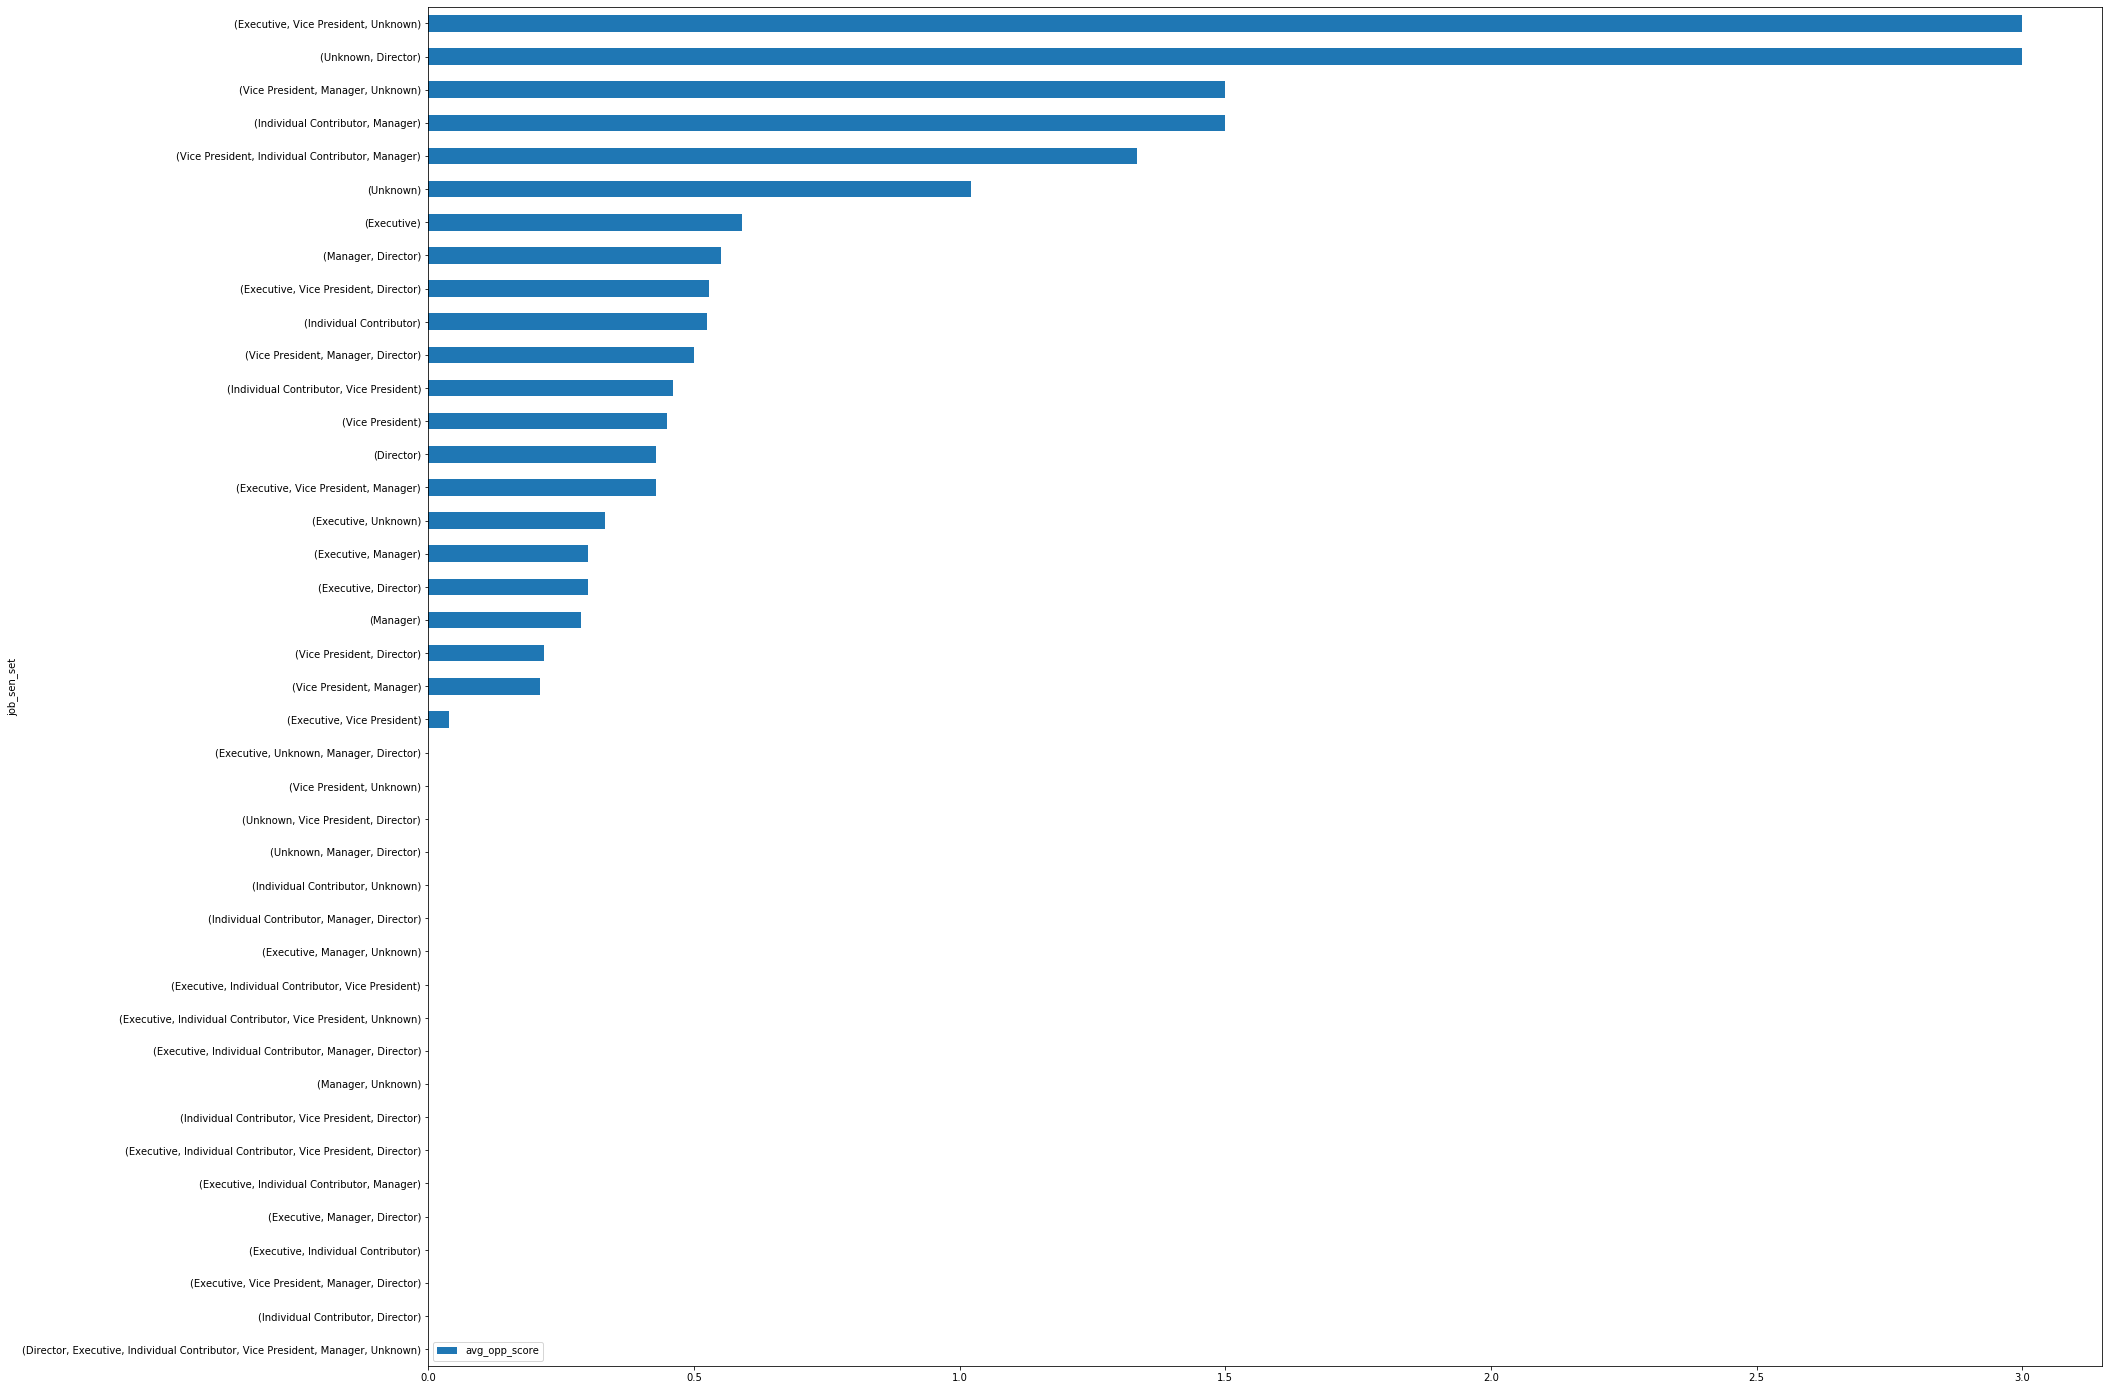

In [28]:
#Plotting the average opportunity score for each job seniority mixture
df_job_desc_q5_updated_new_1.sort_values(by='avg_opp_score', ascending=True).plot.barh(x='job_sen_set', y='avg_opp_score', rot=0,figsize=(30, 25))

# Question 5
#Approach 2: This part of the code is to calculate the opportunities closed for each job mixture

In [29]:
#Creating base line, getting job_seniorty, company_id, latest_stage (opportunity status)
cur.execute('drop table if exists job_desc_q5_1')
cur.execute('create table job_desc_q5_1 as select * from (select a.company_id, a.id person_id, b.touch_type, \
a.job_seniority, b.touch_scheduled_on, c.latest_stage,\
row_number() over(partition by a.company_id, a.job_seniority order by b.touch_scheduled_on) as row_no from \
persons a \
inner join \
(select * from touches where lower(trim(status))="completed") b \
on a.id=b.person_id \
inner join \
(select * from opportunities where latest_stage="Closed Won") c \
on trim(b.touch_scheduled_on)=substr(c.created_at,0,11) and a.company_id=c.company_id) k' )
cur.fetchall()

[]

In [30]:
#Creating a mixture of job seniorities and the touch count for each mixture at each company for opportunities won
cur.execute('select * from job_desc_q5_1')
df_job_desc_q5_1=pd.DataFrame(cur.fetchall())
df_job_desc_q5_1.rename(columns = {0:'company_id',1:'person_id',2:'touch_type',3:'job_seniority',4:'touch_scheduled_on',5:'row_no'}, inplace = True)
df_job_desc_q5_1_updated=df_job_desc_q5_1.groupby("company_id").agg({
    "job_seniority": lambda x: set(x),'touch_type': ['count']
})
df_job_desc_q5_1_updated.head(5)

,job_seniority,touch_type
,<lambda>,count
company_id,,
90,{Manager},2
147,{Vice President},1
266,{Manager},2
326,{Vice President},1
387,{Vice President},1


In [31]:
# Getting the mixture of job seniorities and total sum of touches  for each of the mixture for opportunities won
df_job_desc_q5_1_updated=df_job_desc_q5_1.groupby("company_id").agg({
    "job_seniority": lambda x: frozenset(x),'touch_type': ['count']
}).reset_index().rename(columns={'company_id':'company_id','job_seniority' : 'job_seniority_set','touch_type':'touch_count'})
df_job_desc_q5_1_updated_new=df_job_desc_q5_1_updated
df_job_desc_q5_1_updated_new.columns = [''] * len(df_job_desc_q5_1_updated_new.columns)
df_job_desc_q5_1_updated_new.columns =['company_id', 'job_sen_set', 'touch_count']
df_job_desc_q5_1_updated_new_1=df_job_desc_q5_1_updated_new.groupby("job_sen_set").agg({'touch_count': ['sum']}).reset_index().rename(columns={'job_sen_set' : 'job_sen_set','touch_count':'touch_count'})
df_job_desc_q5_1_updated_new_1.columns = [''] * len(df_job_desc_q5_1_updated_new_1.columns)
df_job_desc_q5_1_updated_new_1.columns =['job_sen_set', 'touch_count']
df_job_desc_q5_1_updated_new_1=df_job_desc_q5_1_updated_new_1.sort_values(by='touch_count', ascending=False)
df_job_desc_q5_1_updated_new_1.head(5)

,job_sen_set,touch_count
10,(Director),49
14,(Vice President),33
3,(Unknown),32
7,(Executive),28
17,"(Executive, Vice President, Director)",27


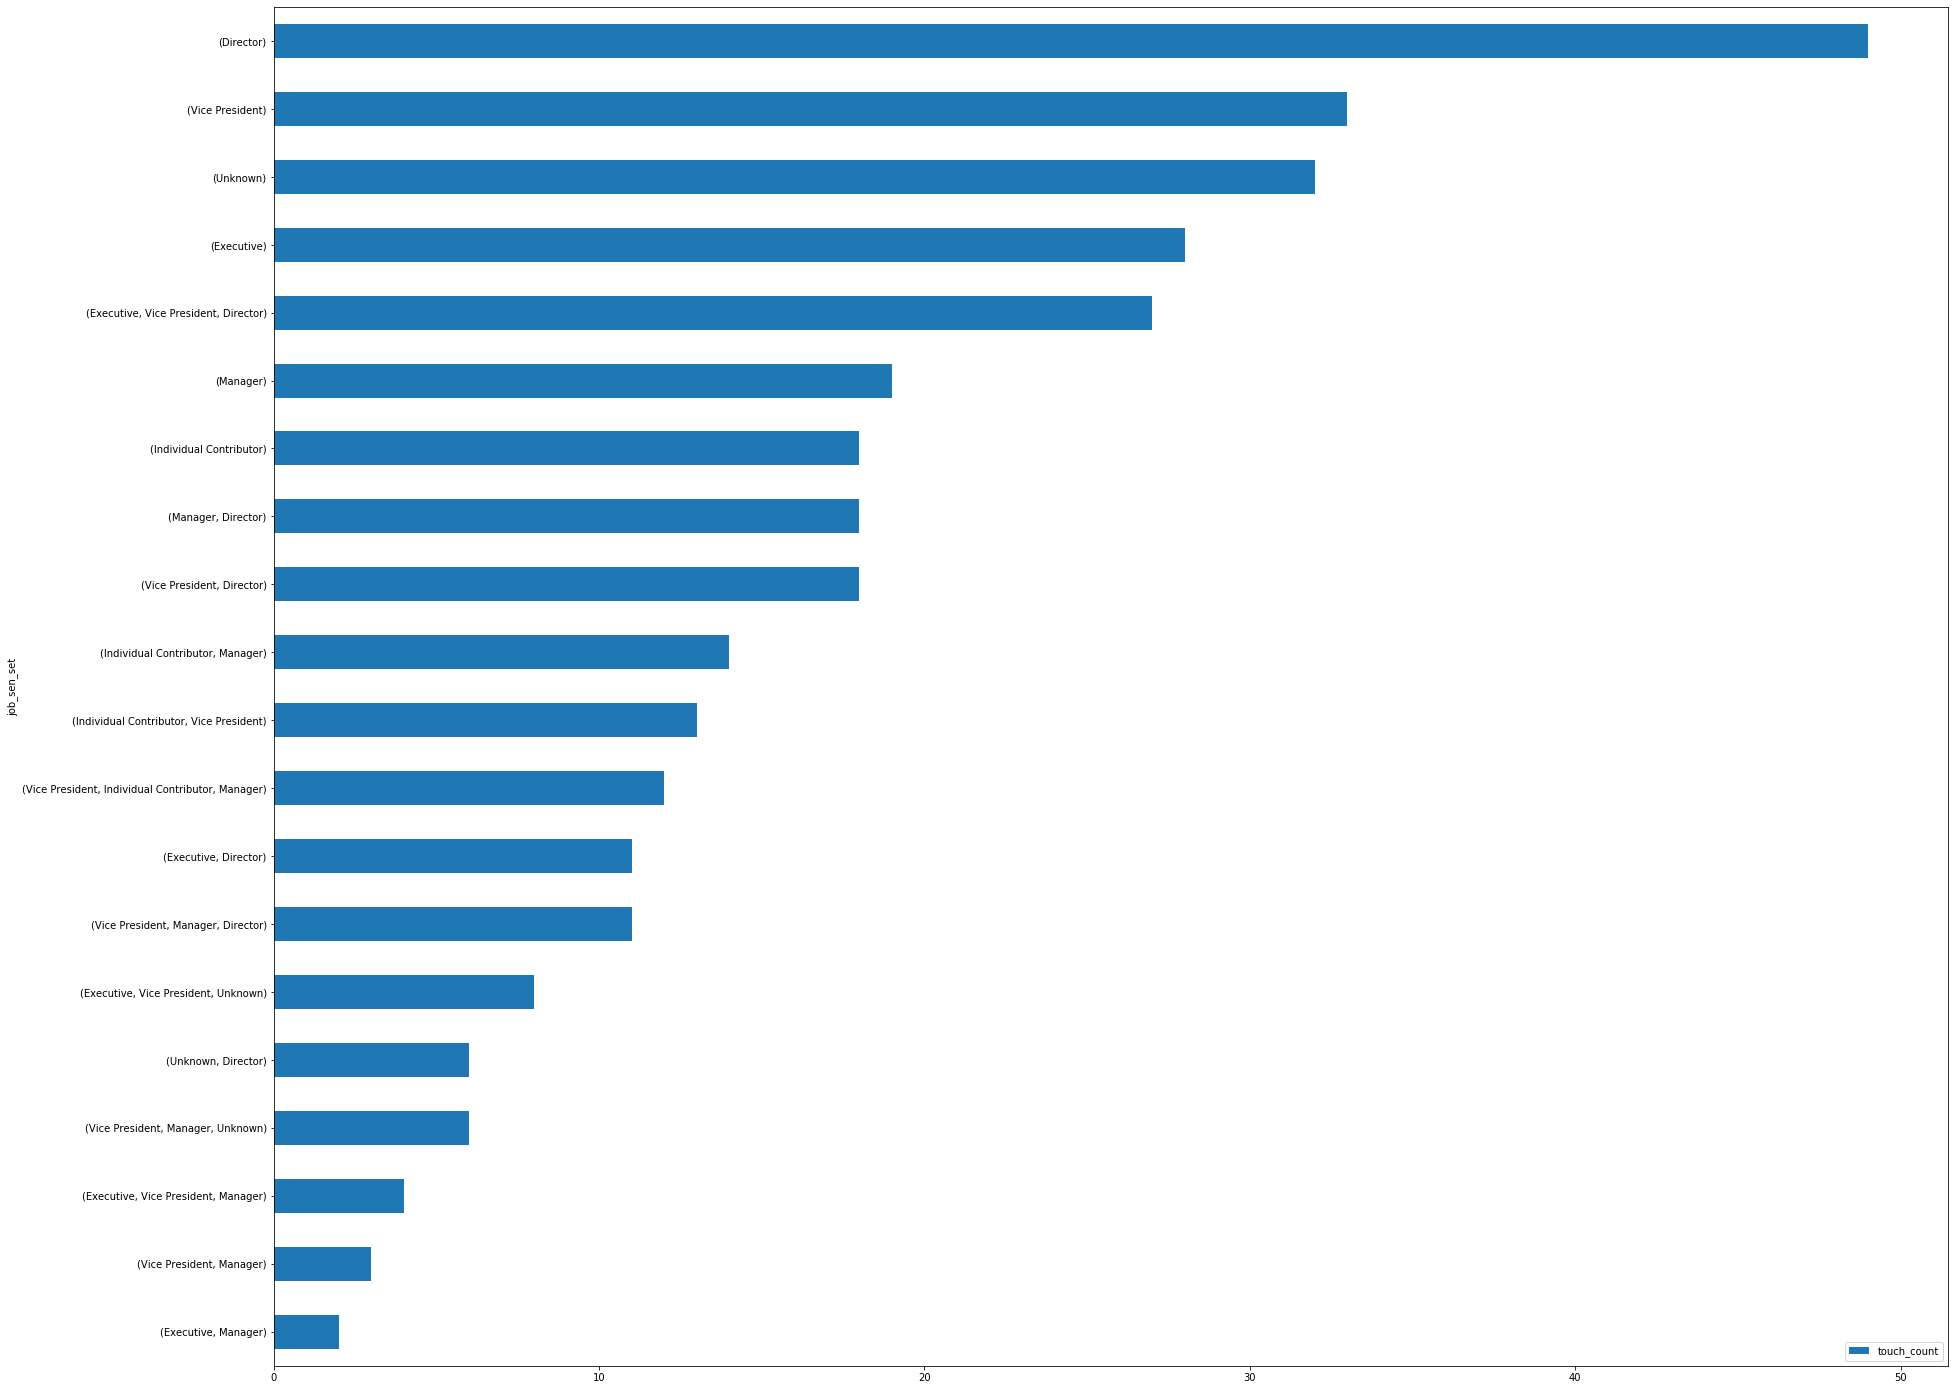

In [32]:
df_job_desc_q5_1_updated_new_1.sort_values(by='touch_count', ascending=True).plot.barh(x='job_sen_set', y='touch_count', rot=0,figsize=(30, 25));